<ipython-input-7-6baba9cc13ae>:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(trajectory[0, index], trajectory[1, index])
<ipython-input-7-6baba9cc13ae>:66: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dot.set_data(trajectory[0, index], trajectory[1, index])


Elapsed time: 3564.02 seconds


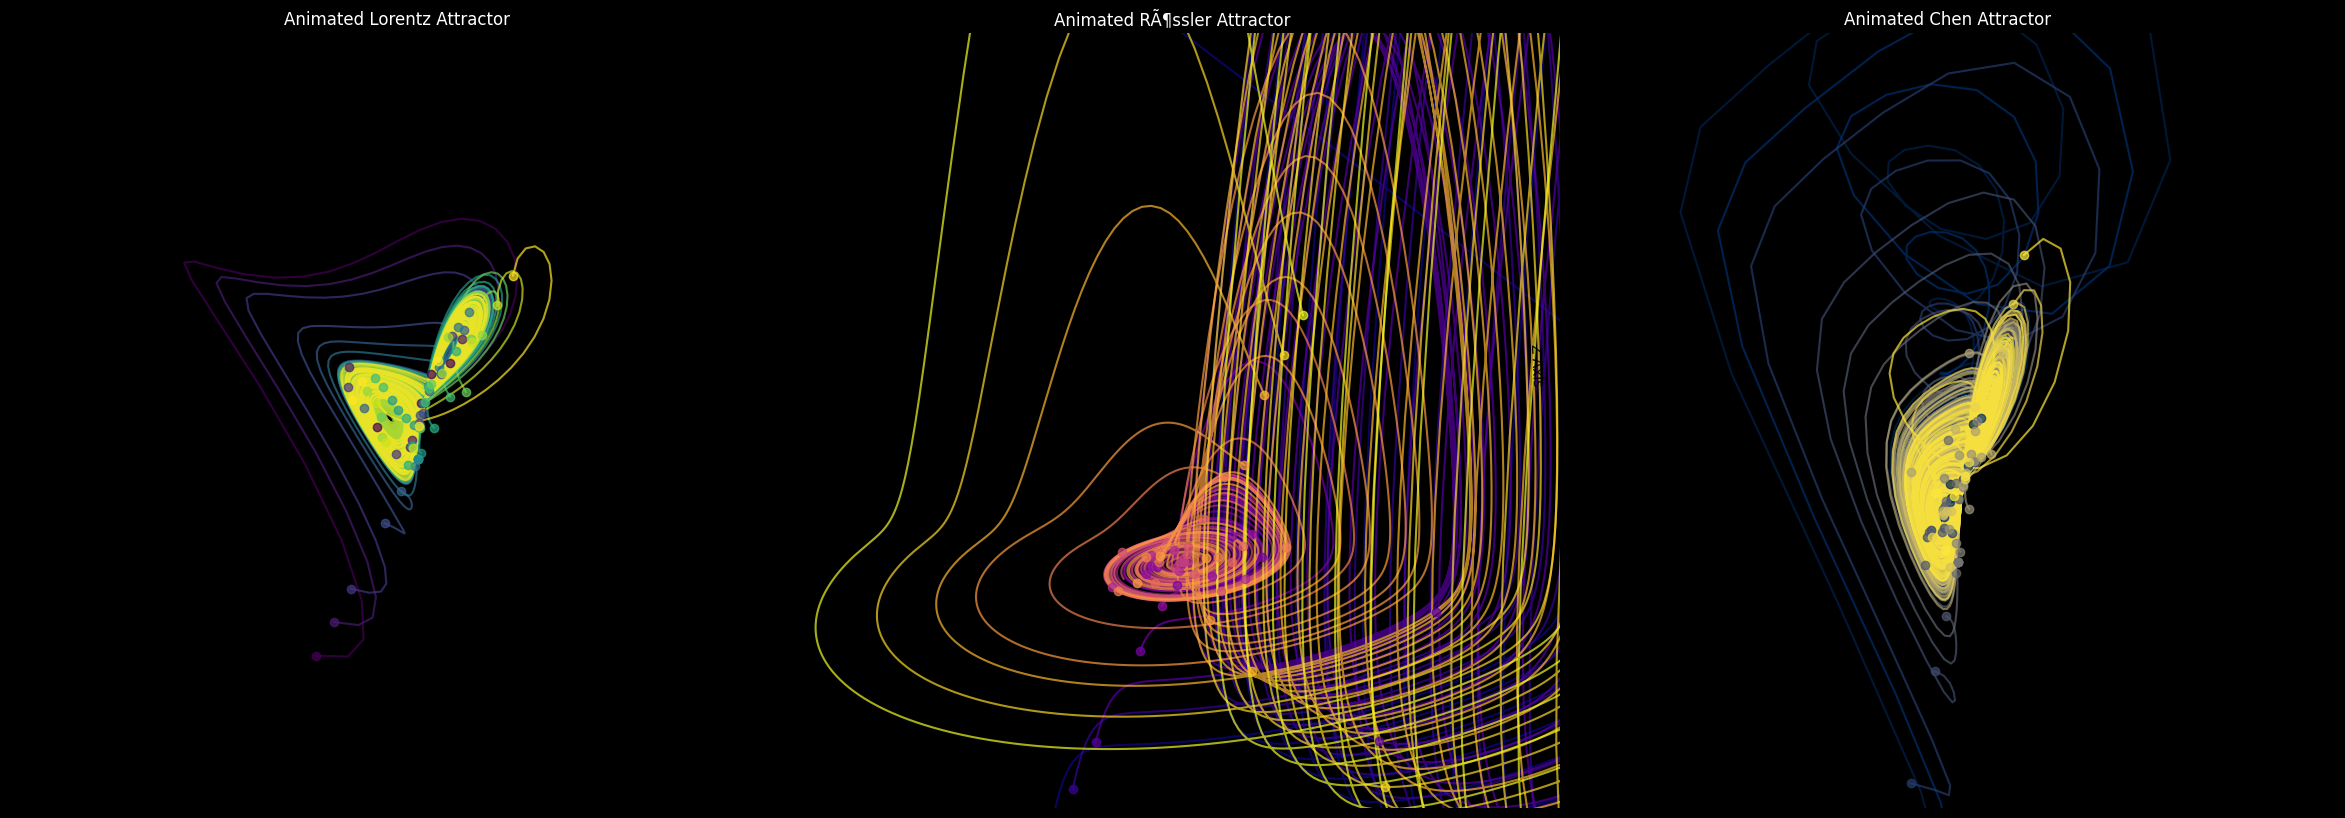

In [ ]:
# The provided code demonstrates the generation of animated attractor plots for three different chaotic systems: Lorentz, Rössler, and Chen attractors.
# First, the necessary packages (numpy, matplotlib, scipy, numba, ffmpeg) are installed. Then, the required modules and functions are imported.
# The code defines several functions, such as lorentz_system, rossler_system, and chen_system, which represent the mathematical equations of the respective chaotic systems. These functions are decorated with @njit to enable just-in-time compilation using Numba for improved performance.
# The compute_trajectory function uses the solve_ivp function from scipy.integrate to numerically solve the system of differential equations and compute the trajectory of each attractor.
# The init function initializes the lines and dots for the attractor plots.
# The update_attractor function updates the positions of the lines and dots at each frame of the animation.
# The animate_attractor function combines the update_attractor function with the manipulation of the 3D plot view to create the animation frames.
# The plot_attractor function orchestrates the generation of the attractor plot by utilizing parallel processing with ProcessPoolExecutor to compute multiple trajectories simultaneously. It also sets up the plot aesthetics and initializes the lines and dots.
# The code then creates a figure with three subplots representing the attractor plots for each system. It sets up the aesthetics of the subplots and assigns the attractor animations to variables (lorentz_ani, rossler_ani, chen_ani).
# The update_all function synchronizes the animation frames for all attractors.
# Finally, the combined animation is created using FuncAnimation, saved as an MP4 file, and displayed. The elapsed time of the entire code execution is calculated and printed.
# Overall, the code generates visually appealing animated plots of chaotic attractors using the provided mathematical equations and parameters.

!apt-get -qq install -y ffmpeg
!pip install -q numpy matplotlib scipy numba

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

from matplotlib.animation import FuncAnimation, writers
import matplotlib.cm as cm
from IPython.display import Video

from concurrent.futures import ProcessPoolExecutor
from numba import njit

import time
start_time = time.time()


# Compute the derivatives for the Lorenz system
    # t: Time
    # xyz: Current state [x, y, z]
    # sigma: Parameter sigma
    # rho: Parameter rho
    # beta: Parameter beta
    # Returns: Derivatives [dx/dt, dy/dt, dz/dt]
@njit
def lorentz_system(t, xyz, sigma, rho, beta):
    x, y, z = xyz
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

# Compute the derivatives for the Rössler system
    # t: Time
    # xyz: Current state [x, y, z]
    # a: Parameter a
    # b: Parameter b
    # c: Parameter c
    # Returns: Derivatives [dx/dt, dy/dt, dz/dt]
@njit
def rossler_system(t, xyz, a, b, c):
    x, y, z = xyz
    return np.array([-y - z, x + a * y, b + z * (x - c)])

# Compute the derivatives for the Chen system
    # t: Time
    # xyz: Current state [x, y, z]
    # a: Parameter a
    # b: Parameter b
    # c: Parameter c
    # Returns: Derivatives [dx/dt, dy/dt, dz/dt]
@njit
def chen_system(t, xyz, a, b, c):
    x, y, z = xyz
    return np.array([a * (y - x), (c - a) * x - x * z + c * y, x * y - b * z])

# Compute the trajectory for a given system
    # args: Tuple containing the system function, initial conditions, and parameters
    # Returns: Interpolated trajectory
def compute_trajectory(args):
    system_function, initial_conditions, params = args
    t_eval = np.linspace(params['t_span'][0], params['t_span'][1], params['t_steps'])
    result = solve_ivp(lambda t, xyz: system_function(t, xyz, *params['system_params']), params['t_span'], initial_conditions, t_eval=t_eval)

    # Interpolate the trajectory to match the expected length
    min_t = max(params['t_span'][0], result.t.min())
    max_t = min(params['t_span'][1], result.t.max())
    t_interp = np.linspace(min_t, max_t, params['t_steps'])

    interp_func = interp1d(result.t, result.y, axis=1)
    interpolated_trajectory = interp_func(t_interp)

    return interpolated_trajectory

# Initialize the lines and dots for animation
    # lines: List of line objects
    # dots: List of dot objects
    # Returns: Updated lines and dots
def init(lines, dots):
    for line, dot_group in zip(lines, dots):
        line.set_data([], [])
        line.set_3d_properties([])
        for dot in dot_group:
            dot.set_data([], [])
            dot.set_3d_properties([])
    return lines + [dot for dot_group in dots for dot in dot_group]

# Update the attractor animation at each frame
    # i: Current frame index
    # trajectories: List of interpolated trajectories
    # lines: List of line objects
    # dots: List of dot objects
    # params: Animation parameters
    # Returns: the lines and dots based on the current frame index
def update_attractor(i, trajectories, lines, dots, params):
    t_steps, particles_per_trajectory = params['t_steps'], params['particles_per_trajectory']
    for trajectory, line, dot_group in zip(trajectories, lines, dots):
        line.set_data(trajectory[0:2, :i])
        line.set_3d_properties(trajectory[2, :i])
        for j, dot in enumerate(dot_group):
            index = (i + j * (t_steps // particles_per_trajectory)) % (t_steps - 1)
            dot.set_data(trajectory[0, index], trajectory[1, index])
            dot.set_3d_properties(trajectory[2, index])

# Animate the attractor
    # i: Current frame index
    # trajectories: List of interpolated trajectories
    # lines: List of line objects
    # dots: List of dot objects
    # params: Animation parameters
    # ax: Axis object
    # Returns the attractor and view angle based on the current frame index
def animate_attractor(i, trajectories, lines, dots, params, ax):
    update_attractor(i, trajectories, lines, dots, params)
    ax.view_init(elev=30, azim=3*i)
    return lines + [dot for dot_group in dots for dot in dot_group]

# Plot the attractor
    # ax: Axis object
    # system_function: System function for the attractor
    # initial_conditions_list: List of initial conditions
    # params: Attractor parameters
    # title: Title of the plot
    # colormap: Colormap for coloring the attractor
    # custom_xlim: Custom x-axis limits
    # custom_ylim: Custom y-axis limits
    # custom_zlim: Custom z-axis limits
    # Compute trajectories in parallel using ProcessPoolExecutor
def plot_attractor(ax, system_function, initial_conditions_list, params, title, colormap, custom_xlim=None, custom_ylim=None, custom_zlim=None):
    with ProcessPoolExecutor() as executor:
      trajectories = list(executor.map(compute_trajectory, [(system_function, init_cond, params) for init_cond in initial_conditions_list]))

    ax.set(xlabel="X Axis", ylabel="Y Axis", zlabel="Z Axis", title=title)
    ax.xaxis.labelpad, ax.yaxis.labelpad, ax.zaxis.labelpad = 15, 15, 15
    ax.title.set_position([.5, 1.05])

    colors = colormap(np.linspace(0, 1, len(initial_conditions_list)))
    lines = [ax.plot([], [], [], lw=1.5, alpha=0.7, color=color)[0] for color in colors]
    dots = [[ax.plot([], [], [], marker='o', markersize=6, alpha=0.7, color=color)[0] for _ in range(params['particles_per_trajectory'])] for color in colors]
    dots_flat = [dot for dot_group in dots for dot in dot_group]

    ax.set_xlim(custom_xlim or (min(min(traj[0]) for traj in trajectories), max(max(traj[0]) for traj in trajectories)))
    ax.set_ylim(custom_ylim or (min(min(traj[1]) for traj in trajectories), max(max(traj[1]) for traj in trajectories)))
    ax.set_zlim(custom_zlim or (min(min(traj[2]) for traj in trajectories), max(max(traj[2]) for traj in trajectories)))

    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, animate_attractor, frames=params['t_steps'], fargs=(trajectories, lines, dots, params, ax), init_func=lambda: init(lines, dots), interval=params['animation_speed'], blit=True)
    return ani

# List of initial conditions for the attractors
initial_conditions_list = [
    [-30,-30,-30],
    [-25,-25,-25],
    [-20,-20,-20],
    [-10,-10,-10],
    [-5, -5, -5],
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
    [5, 5, 5],
    [10, 10, 10],
    [15, 15, 5],
    [20, 20, 20],
    [25, 25, 25],
    [30, 30, 30]
]

# Parameters for the Lorentz attractor
lorentz_params = {
'system_params': (10, 28, 8/3),
't_span': (0, 50),
't_steps': 5000,
'animation_speed': 3,
'particles_per_trajectory': 5
}

# Parameters for the Rössler attractor
rossler_params = {
'system_params': (0.2, 0.2, 5.7),
't_span': (0, 50),
't_steps': 5000,
'animation_speed': 3,
'particles_per_trajectory': 5
}

# Parameters for the Chen attractor
chen_params = {
    'system_params': (40, 3, 28),
    't_span': (0, 50),
    't_steps': 5000,
    'animation_speed': 3,
    'particles_per_trajectory': 5
}

# Create the figure and subplots
fig = plt.figure(figsize=(30, 12))
fig.subplots_adjust(wspace=0, hspace=0)
fig.patch.set_facecolor('black')

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

# Set the visual properties of the subplots
for ax in [ax1, ax2, ax3]:
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_facecolor('black')
    ax.xaxis.pane.set_edgecolor('black')
    ax.yaxis.pane.set_edgecolor('black')
    ax.zaxis.pane.set_edgecolor('black')
    ax.xaxis.pane.set_alpha(0.5)
    ax.yaxis.pane.set_alpha(0.5)
    ax.zaxis.pane.set_alpha(0.5)
    ax.xaxis.line.set_color("black")
    ax.yaxis.line.set_color("black")
    ax.zaxis.line.set_color("black")
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.zaxis.label.set_color('black')
    ax.tick_params(colors='black')
    ax.title.set_color('white')

# Create animations for each attractor
lorentz_ani = plot_attractor(ax1, lorentz_system, initial_conditions_list, lorentz_params, "Animated Lorentz Attractor", cm.viridis)
rossler_ani = plot_attractor(ax2, rossler_system, initial_conditions_list, rossler_params, "Animated Rössler Attractor", cm.plasma, custom_xlim=(-25, 25), custom_ylim=(-35, 35), custom_zlim=(0, 100))
chen_ani = plot_attractor(ax3, chen_system, initial_conditions_list, chen_params, "Animated Chen Attractor", cm.cividis, custom_xlim=(-30, 30), custom_ylim=(-30, 30), custom_zlim=(0, 60))

# Create a function to update all attractors simultaneously
def update_all(i):
    animate_attractor(i, *lorentz_ani._args)
    animate_attractor(i, *rossler_ani._args)
    animate_attractor(i, *chen_ani._args)
    return []

# Create the combined animation
combined_ani = FuncAnimation(fig, update_all, frames=lorentz_params['t_steps'], interval=lorentz_params['animation_speed'], blit=True)

# Save the combined animation as an MP4 file
Writer = writers['ffmpeg']
writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=3600)
combined_ani.save('combined_attractors.mp4', writer=writer)

# Display the combined video clip
Video("combined_attractors.mp4")

# Calculate and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")